# Simulation einer PSK-Übertragung

## Systemmodell

Da sich dieses Jupyter-Notebook mit der Datenentscheidung und den Fehlerwahrscheinlichkeiten beschäftigt, gehen wir von einem zeitdiskreten Systemmodell aus, welches aus dem zeitkontinuierlichen System durch ideale Abtastung im Symboltakt hervorgeht. Bei idealer Filterung an Sender und Empfänger treten keine Intersymbolinterferenzen auf und das Empfangssymbol zu einem beliegiben Zeitpunkt lautet

\begin{equation}
    y = d + n \; .
\end{equation}

Dabei beschreibt $d$ das Datensymbol aus der Menge $\mathbb{D}$ und $n$ das additive, weiße, gaußverteilte Rauschen. Bei der Maximum-Likelihood-Detektion bestimmt der Empfänger nun dasjenige Symbol aus der Menge $\mathbb{D}$, welches den kleinsten euklidischen Abstand zum Empfangswert $y$ hat. Es gilt 

\begin{equation}
    \hat{d}^{\mathsf{ML}} = \arg \! \max_{\tilde{d} \in \mathbb{D}} p(y \mid \tilde{d})
     = \arg \! \min_{\tilde{d} \in \mathbb{D}} |y - \tilde{d}|^2 \; .
\end{equation}

In der folgenden Simulation wird ein zufälliger Vektor von Informationsbit $\mathbf{u}$ erzeugt, welcher dann ASK-moduliert wird. Anschließend wird auf die Datensymbole $\mathbf{d}$ weißes, gaußverteiltes Rauschen $\mathbf{n}$ addiert und aus den so erhaltenen Empfangssymbolen $\mathbf{y}$ die Datensymbole $\hat{\mathbf{d}}$ nach dem Maximum-Likelihood-Prinzip geschätzt. Die Detektionsfehler werden durch Vergleich mit der wahren Informationsbitfolge $\mathbf{d}$ ermittelt. Dabei wird Gray-Mapping und natürliches Mapping verwendet. 

## Analyse der 16-ASK

In [28]:
import sys
import numpy as np
import matplotlib.pyplot as plt

ECCpath = '../ECCpython'
if (not ECCpath==None) and (not ECCpath in sys.path):
    sys.path.append(ECCpath)

from Modulation.modulation import Modulation

# cardinality of modulation scheme
M = 16
m = int(np.log2(M))

# number of information bits
N_info_bits = 400
N_symbols = int(N_info_bits / m)
# number of repetitions
N_runs = 100

# signal-to-noise ratio and noise variance
SNRdB = np.linspace(0,30,16)
SNR = 10**(SNRdB/10)

# noise variance of real and imaginary parts 
sigma2_N = 0.5 / SNR
sigma_N = np.sqrt(sigma2_N)

# initialize ASK object
ASKnat = Modulation(m, coding_type='natural',modulation_type='ASK')
ASKgray = Modulation(m, coding_type='gray',modulation_type='ASK')

ber_nat_ask  = np.zeros(len(SNRdB))
ber_gray_ask = np.zeros(len(SNRdB))
ser_ask = np.zeros(len(SNRdB))

# run over all SNRs
for snr in np.arange(len(SNRdB)):
    
    err_bits_nat  = 0
    err_bits_gray = 0
    err_symbols = 0

    # run over all repetitions
    for repetitions in np.arange(N_runs):
    
        # generate vector with information bits
        info_bits = np.random.randint(0,2,N_info_bits)
    
        # ASK modulation with natural and Gray mapping
        d_nat = ASKnat.modulate(info_bits.flatten())
        d_gray = ASKgray.modulate(info_bits.flatten())

        # AWGN
        awgn = np.random.normal(0,sigma_N[snr],N_symbols)
        y_nat  = d_nat + awgn
        y_gray = d_gray + awgn
        
        # detection of ASK symbols
        hat_info_bits_nat, hat_d_nat = ASKnat.demodulate(y_nat, return_Xhat=True)
        hat_info_bits_gray, hat_d_gray = ASKgray.demodulate(y_gray, return_Xhat=True)
        
        # determine number of errors
        compare_bits = np.where(info_bits == hat_info_bits_nat,0,1)
        err_bits_nat  += np.sum(compare_bits)
        compare_symbols = np.sum(compare_bits.reshape((-1,m)),axis=1)
        err_symbols += np.sum(np.where(compare_symbols == 0,0,1))

        compare_bits = np.where(info_bits == hat_info_bits_gray,0,1)
        err_bits_gray  += np.sum(compare_bits)
        # count symbol errors for natural and Gray mapping
        compare_symbols = np.sum(compare_bits.reshape((-1,m)),axis=1)
        err_symbols += np.sum(np.where(compare_symbols == 0,0,1))

    ber_nat_ask[snr] = err_bits_nat / N_info_bits / N_runs
    ber_gray_ask[snr] = err_bits_gray / N_info_bits / N_runs
    ser_ask[snr] = err_symbols / N_symbols / N_runs / 2

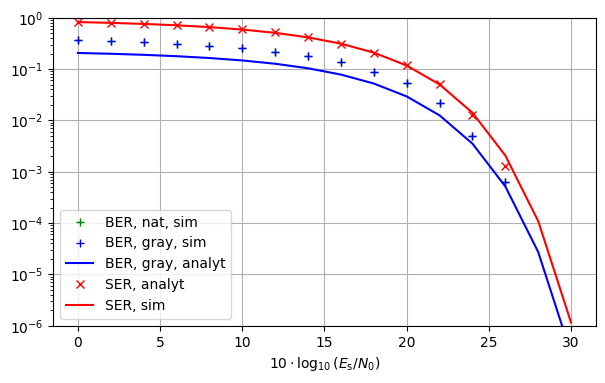

In [29]:
from scipy import special as sp

# analytical result
ser_analyt_ask = (M-1)/M * sp.erfc(np.sqrt(3/(M**2-1)*SNR))
ber_analyt_ask = ser_analyt_ask / m

fig1 = plt.figure(figsize=(7,4))
ax1 = fig1.add_subplot(111)
ax1.semilogy(SNRdB, ber_nat_ask, 'g+', label='BER, nat, sim')
ax1.semilogy(SNRdB, ber_gray_ask, 'b+', label='BER, gray, sim')
ax1.semilogy(SNRdB, ber_analyt_ask, 'b-', label='BER, gray, analyt')
ax1.semilogy(SNRdB, ser_ask, 'rx', label='SER, analyt')
ax1.semilogy(SNRdB, ser_analyt_ask, 'r-', label='SER, sim')
plt.xlabel('$10 \cdot \log_{10}(E_{\mathrm{s}}/N_0)$')
plt.ylim(1e-6,1)
plt.grid(True)
plt.legend()


Bei der Symbolfehlerrate ist eine sehr gute Übereinstimmung zwischen der analytischen Lösung und der Simulation (Marker) über den gesamten SNR-Bereich festzustellen. Die kleinen Abweichungen werden durch die endliche Anzahl an simulierten Datensymbolen hervorgerufen, die zu einer begrenzten Genauigkeit bei der Simulation der Fehlerrate führen.

Dem obigen Bild ist ferner zu entnehmen, dass die Bitfehlerraten generell kleiner als die Symbolfehlerraten sind. Dies liegt daran, dass bei einem Symbolfehler nicht zwangsläufig alle Bit falsch entschieden werden müssen. Trotz einer falschen Symbolentscheidung können einzelne Bit richtig entschieden werden, so dass die Bitfehlerwahrscheinlichkeit niedriger als dieSymbolfehlerwahrscheinlichkeit ist. Bei Fehlentscheidungen werden vorwiegend benachbarte Symbole verwechselt. Dies gilt insbesonderen für mittlere und hohe SNR. Da sich benachbarte Symbole beim Gray-Mapping diese sich nur in einer Bitposition unterscheiden, ergibt sich die mittlere Bitfehlerwahrscheinlichkeit näherungsweise durch

\begin{equation}
    P_{\mathrm{b}} \approx \frac{P_{\mathrm{s}}}{m}
\end{equation}

aus der Symbolfehlerrate $P_{\mathrm{s}}$. Sie ist niedriger als beim natürlichen Mapping, bei dem benachbarte Symbole sich auch durch mehrere Bit unterscheiden können.

Auch die simulierte Bitfehlerrate stimmen sehr gut mit der analytisch berechneten überein. Lediglich für sehr niedrige SNRs sind die analytischen Werte zu gering. Dies liegt an der oben erwähnten Approximation der Bitfehlerrate. Für sehr kleine SNR werden auch häufiger nicht benachbarte Symbole verwechselt, welche sich in mehr als nur einer Bitposition unterscheiden. Dadurch wird die obige Approximation zu optimistisch.

